# Task 1.1: Exploratory Data Analysis - Fraud Data

## Objective
Explore and understand the e-commerce fraud dataset (`Fraud_Data.csv`) to:
1. Understand data structure, types, and quality
2. Identify missing values and duplicates
3. Analyze class distribution (fraud vs non-fraud)
4. Discover patterns and relationships in features

## Key Questions
- How imbalanced is the fraud class?
- What are the distributions of key features?
- Are there obvious patterns that distinguish fraud from legitimate transactions?

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add project root to path for imports
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project imports
from src.data.loader import load_fraud_data
from src.data.cleaning import clean_fraud_data, get_missing_value_summary, get_duplicate_summary

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Load Raw Data

In [2]:
# Load the raw fraud data
DATA_PATH = project_root / "data" / "raw" / "Fraud_Data.csv"

df_raw = load_fraud_data(DATA_PATH)
print(f"Dataset shape: {df_raw.shape}")
print(f"Columns: {list(df_raw.columns)}")

Dataset shape: (151112, 11)
Columns: ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class']


In [3]:
# First look at the data
df_raw.head(10)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0


In [4]:
# Data types and info
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [5]:
# Basic statistics for numeric columns
df_raw.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [ ]:
from IPython.display import Markdown, display

n_rows, n_cols = df_raw.shape

display(
    Markdown(
        f"""
### Interpretation: Raw Data Overview

- **Dataset size**: `{n_rows:,}` rows × `{n_cols}` columns.
- **Time fields**: `signup_time` and `purchase_time` are provided and will be parsed to datetimes during cleaning.
- **Numeric fields**: `purchase_value`, `age`, and `ip_address` are expected to be numeric (note any coercion warnings during cleaning).

**Initial note**: At this stage we focus on understanding the data structure and quality; fraud modeling decisions depend heavily on the class imbalance analysis below.
"""
    )
)

## 2. Data Quality Assessment

In [6]:
# Check for missing values
missing_summary = get_missing_value_summary(df_raw)
if len(missing_summary) > 0:
    print("Missing Values Found:")
    display(missing_summary)
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


In [7]:
# Check for duplicates
dup_summary = get_duplicate_summary(df_raw)
print("Duplicate Analysis:")
for key, value in dup_summary.items():
    print(f"  {key}: {value}")

Duplicate Analysis:
  total_rows: 151112
  duplicate_rows: 0
  unique_rows: 151112
  duplicate_percent: 0.0


In [ ]:
from IPython.display import Markdown, display

missing_summary = get_missing_value_summary(df_raw)
dup_summary = get_duplicate_summary(df_raw)

missing_cols = len(missing_summary)
duplicate_rows = dup_summary.get("duplicate_rows", 0)
dup_pct = dup_summary.get("duplicate_percent", 0)

missing_text = (
    "No missing values were detected in the raw dataset." if missing_cols == 0 else
    f"Missing values were detected in **{missing_cols}** columns."
)

display(
    Markdown(
        f"""
### Interpretation: Data Quality

- **Missing values**: {missing_text}
- **Duplicates**: `{duplicate_rows:,}` duplicate rows ({dup_pct:.4f}% of the dataset).

**Planned cleaning actions**
- Parse `signup_time` and `purchase_time` into proper datetime types.
- Remove exact duplicate rows.
- For missing categorical values (if any), fill with `"unknown"`.

This ensures downstream feature engineering (time-based and velocity features) is consistent and reproducible.
"""
    )
)

## 3. Clean the Data

In [8]:
# Apply cleaning function
df_clean, cleaning_report = clean_fraud_data(df_raw)

print("Cleaning Report:")
for key, value in cleaning_report.items():
    print(f"  {key}: {value}")

Cleaning Report:
  original_rows: 151112
  duplicates_removed: 0
  missing_values: {}
  final_rows: 151112


In [9]:
# Verify cleaned data types
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 12.7+ MB


## 4. Class Distribution Analysis (Target Variable)

In [10]:
# Class distribution
class_counts = df_clean['class'].value_counts()
class_pct = df_clean['class'].value_counts(normalize=True) * 100

print("Class Distribution:")
print(f"  Non-Fraud (0): {class_counts[0]:,} ({class_pct[0]:.2f}%)")
print(f"  Fraud (1):     {class_counts[1]:,} ({class_pct[1]:.2f}%)")
print(f"\nImbalance Ratio: 1:{class_counts[0]/class_counts[1]:.1f}")

Class Distribution:
  Non-Fraud (0): 136,961 (90.64%)
  Fraud (1):     14,151 (9.36%)

Imbalance Ratio: 1:9.7


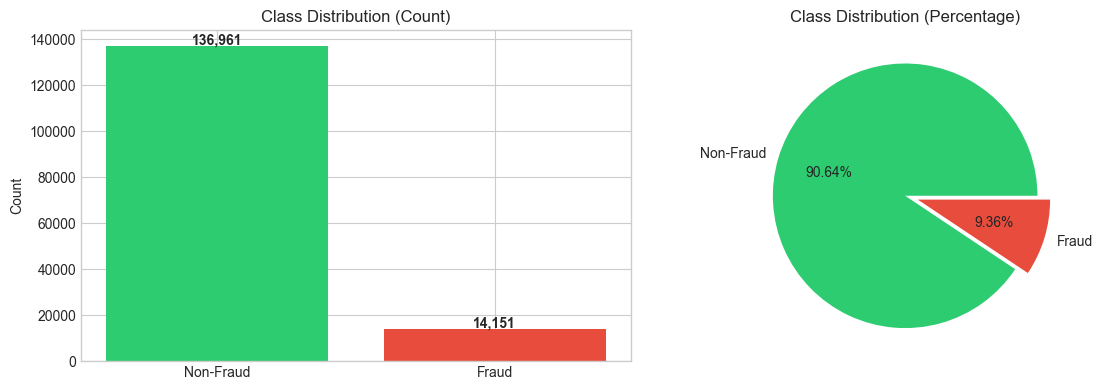

In [11]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
colors = ['#2ecc71', '#e74c3c']
axes[0].bar(['Non-Fraud', 'Fraud'], class_counts.values, color=colors)
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution (Count)')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
axes[1].pie(class_counts.values, labels=['Non-Fraud', 'Fraud'], autopct='%1.2f%%',
            colors=colors, explode=[0, 0.1])
axes[1].set_title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

In [ ]:
from IPython.display import Markdown, display

overall_rate = df_clean['class'].mean() * 100
imbalance_ratio = class_counts[0] / class_counts[1]

display(
    Markdown(
        f"""
### Interpretation: Class Imbalance

- **Fraud rate**: `{overall_rate:.4f}%` of transactions are labeled fraud.
- **Imbalance ratio**: approximately **1:{imbalance_ratio:.1f}** (non-fraud to fraud).

**Implications for modeling**
- **Accuracy is misleading**: a model that predicts *all* transactions as non-fraud can still achieve very high accuracy.
- We should evaluate using **AUC-PR**, **F1-score**, and the **confusion matrix**.
- Resampling strategies (e.g., **SMOTE** or undersampling) must be applied **only on the training split** to avoid leakage.
"""
    )
)

## 5. Univariate Analysis

### 5.1 Numeric Features

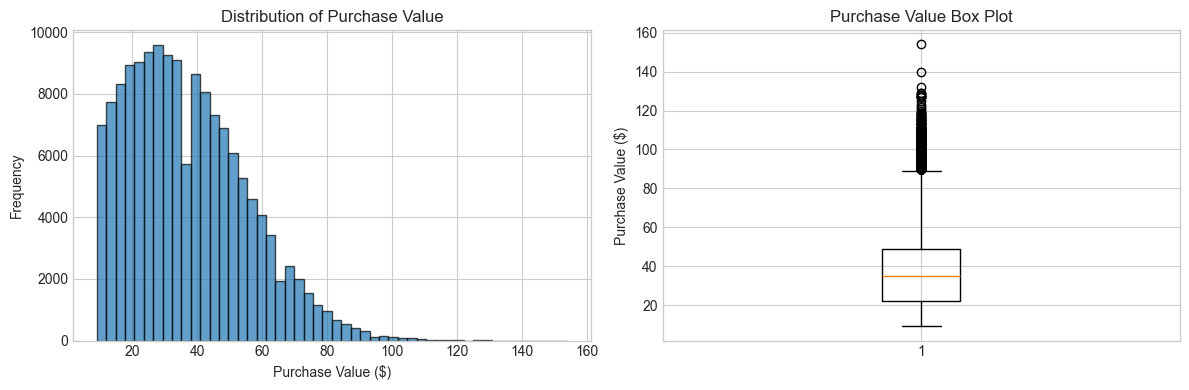

Purchase Value Statistics:
count    151112.000000
mean         36.935372
std          18.322762
min           9.000000
25%          22.000000
50%          35.000000
75%          49.000000
max         154.000000
Name: purchase_value, dtype: float64


In [12]:
# Purchase value distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(df_clean['purchase_value'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Purchase Value ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Purchase Value')

# Box plot
axes[1].boxplot(df_clean['purchase_value'], vert=True)
axes[1].set_ylabel('Purchase Value ($)')
axes[1].set_title('Purchase Value Box Plot')

plt.tight_layout()
plt.show()

print(f"Purchase Value Statistics:")
print(df_clean['purchase_value'].describe())

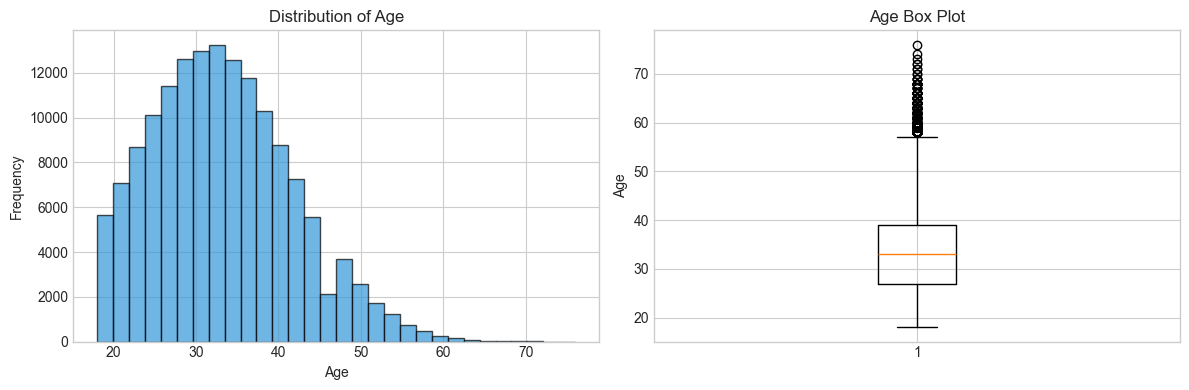

Age Statistics:
count    151112.000000
mean         33.140704
std           8.617733
min          18.000000
25%          27.000000
50%          33.000000
75%          39.000000
max          76.000000
Name: age, dtype: float64


In [13]:
# Age distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df_clean['age'], bins=30, edgecolor='black', alpha=0.7, color='#3498db')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Age')

axes[1].boxplot(df_clean['age'], vert=True)
axes[1].set_ylabel('Age')
axes[1].set_title('Age Box Plot')

plt.tight_layout()
plt.show()

print(f"Age Statistics:")
print(df_clean['age'].describe())

### 5.2 Categorical Features

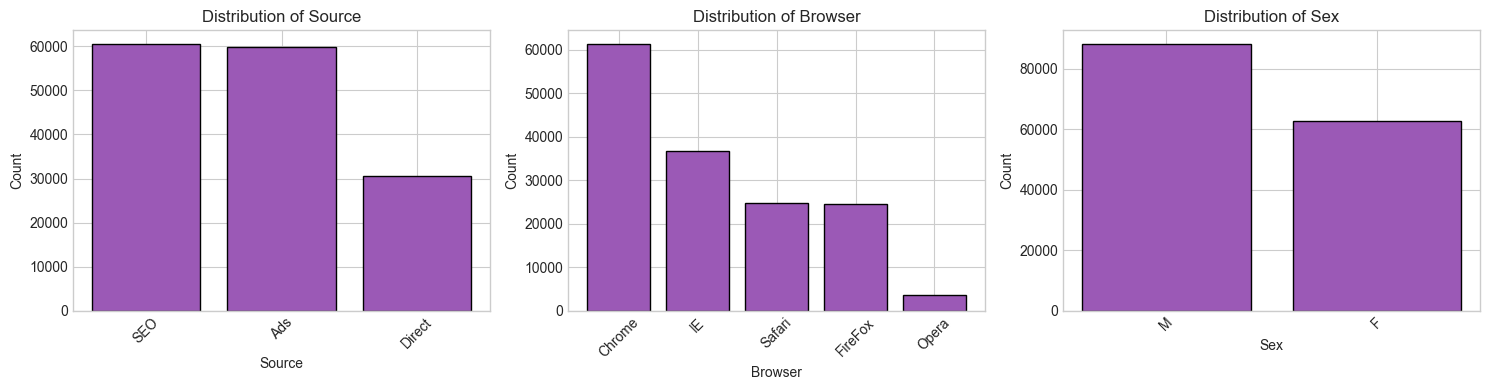

In [14]:
# Categorical columns analysis
cat_cols = ['source', 'browser', 'sex']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(cat_cols):
    value_counts = df_clean[col].value_counts()
    axes[i].bar(value_counts.index, value_counts.values, color='#9b59b6', edgecolor='black')
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'Distribution of {col.capitalize()}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [15]:
# Value counts for each categorical
for col in cat_cols:
    print(f"\n{col.upper()}:")
    print(df_clean[col].value_counts())


SOURCE:
source
SEO       60615
Ads       59881
Direct    30616
Name: count, dtype: int64

BROWSER:
browser
Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: count, dtype: int64

SEX:
sex
M    88293
F    62819
Name: count, dtype: int64


In [ ]:
from IPython.display import Markdown, display

# Pull quick distribution stats that are robust across datasets
pv_desc = df_clean['purchase_value'].describe()
age_desc = df_clean['age'].describe()

most_common_source = df_clean['source'].value_counts().idxmax() if 'source' in df_clean.columns else None
most_common_browser = df_clean['browser'].value_counts().idxmax() if 'browser' in df_clean.columns else None

outlier_hint = (
    "The distribution shows a long right tail (high-value outliers)" 
    if pv_desc['max'] > pv_desc['75%'] * 3 else
    "The distribution does not show extreme high-value outliers"
)

display(
    Markdown(
        f"""
### Interpretation: Feature Distributions

- **`purchase_value`**: median `{pv_desc['50%']:.2f}`, 75th percentile `{pv_desc['75%']:.2f}`, max `{pv_desc['max']:.2f}`. {outlier_hint}.
- **`age`**: median `{age_desc['50%']:.1f}`, range `{age_desc['min']:.1f}`–`{age_desc['max']:.1f}`.
- **Most common categories**:
  - `source`: `{most_common_source}`
  - `browser`: `{most_common_browser}`

**Why it matters**
- Skewed monetary variables often benefit from robust scaling / log transforms (we’ll decide during modeling).
- Categorical distributions inform whether one-hot encoding will create many sparse columns.
"""
    )
)

## 6. Bivariate Analysis (Features vs Target)

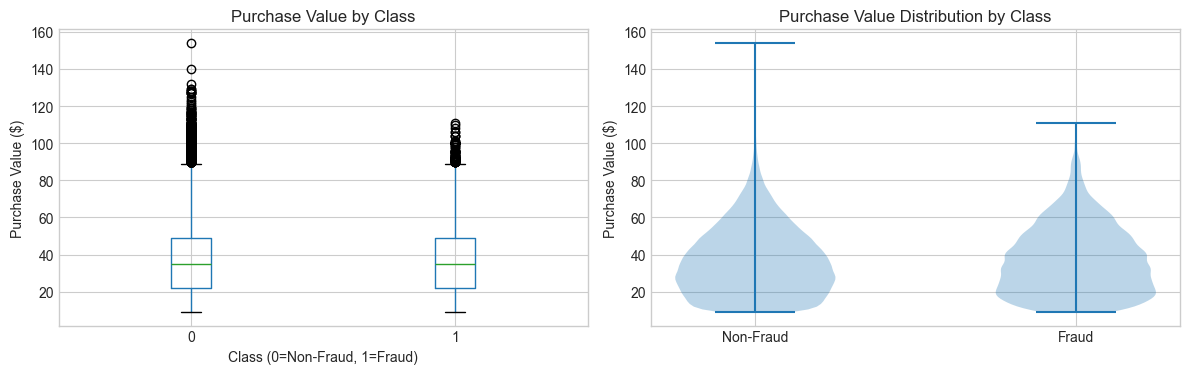

In [16]:
# Purchase value by fraud class
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Box plot
df_clean.boxplot(column='purchase_value', by='class', ax=axes[0])
axes[0].set_xlabel('Class (0=Non-Fraud, 1=Fraud)')
axes[0].set_ylabel('Purchase Value ($)')
axes[0].set_title('Purchase Value by Class')
plt.suptitle('')  # Remove auto-title

# Violin plot
parts = axes[1].violinplot(
    [df_clean[df_clean['class']==0]['purchase_value'].values,
     df_clean[df_clean['class']==1]['purchase_value'].values],
    positions=[0, 1]
)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Non-Fraud', 'Fraud'])
axes[1].set_ylabel('Purchase Value ($)')
axes[1].set_title('Purchase Value Distribution by Class')

plt.tight_layout()
plt.show()

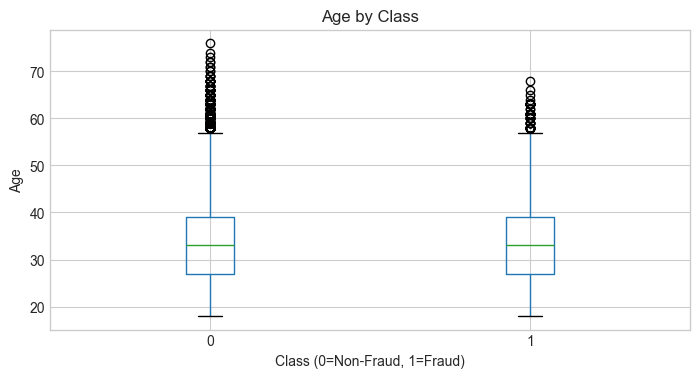

Age by Class:
          count       mean       std   min   25%   50%   75%   max
class                                                             
0      136961.0  33.122356  8.622678  18.0  27.0  33.0  39.0  76.0
1       14151.0  33.318281  8.568001  18.0  27.0  33.0  39.0  68.0


In [17]:
# Age by fraud class
fig, ax = plt.subplots(figsize=(8, 4))

df_clean.boxplot(column='age', by='class', ax=ax)
ax.set_xlabel('Class (0=Non-Fraud, 1=Fraud)')
ax.set_ylabel('Age')
ax.set_title('Age by Class')
plt.suptitle('')
plt.show()

# Statistics by class
print("Age by Class:")
print(df_clean.groupby('class')['age'].describe())

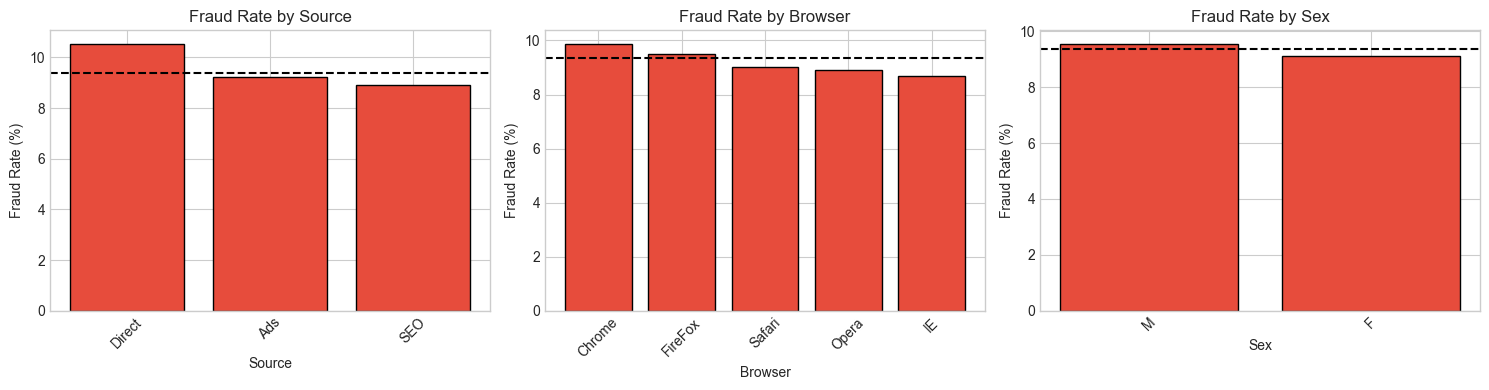

In [18]:
# Fraud rate by categorical features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(cat_cols):
    fraud_rate = df_clean.groupby(col)['class'].mean() * 100
    fraud_rate = fraud_rate.sort_values(ascending=False)
    
    axes[i].bar(fraud_rate.index, fraud_rate.values, color='#e74c3c', edgecolor='black')
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel('Fraud Rate (%)')
    axes[i].set_title(f'Fraud Rate by {col.capitalize()}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].axhline(y=df_clean['class'].mean()*100, color='black', linestyle='--', label='Overall')

plt.tight_layout()
plt.show()

In [19]:
# Fraud rate statistics by category
for col in cat_cols:
    print(f"\nFraud Rate by {col.upper()}:")
    fraud_stats = df_clean.groupby(col).agg(
        total_count=('class', 'count'),
        fraud_count=('class', 'sum'),
        fraud_rate=('class', 'mean')
    ).round(4)
    fraud_stats['fraud_rate'] = (fraud_stats['fraud_rate'] * 100).round(2)
    print(fraud_stats.sort_values('fraud_rate', ascending=False))


Fraud Rate by SOURCE:
        total_count  fraud_count  fraud_rate
source                                      
Direct        30616         3226       10.54
Ads           59881         5513        9.21
SEO           60615         5412        8.93

Fraud Rate by BROWSER:
         total_count  fraud_count  fraud_rate
browser                                      
Chrome         61432         6069        9.88
FireFox        24610         2342        9.52
Safari         24667         2225        9.02
Opera           3676          328        8.92
IE             36727         3187        8.68

Fraud Rate by SEX:
     total_count  fraud_count  fraud_rate
sex                                      
M          88293         8434        9.55
F          62819         5717        9.10


In [ ]:
from IPython.display import Markdown, display

# Compare medians by class for a compact, dataset-specific interpretation
pv_medians = df_clean.groupby('class')['purchase_value'].median()
age_medians = df_clean.groupby('class')['age'].median()

# Best-effort: pick the top categorical level by fraud rate for each cat col
high_risk = {}
for col in cat_cols:
    rates = df_clean.groupby(col)['class'].mean().sort_values(ascending=False)
    if len(rates) > 0:
        high_risk[col] = (rates.index[0], rates.iloc[0] * 100)

risk_lines = "\n".join([f"- **{k}**: `{v[0]}` (fraud rate `{v[1]:.2f}%`)" for k, v in high_risk.items()])

pv_delta = pv_medians.get(1, np.nan) - pv_medians.get(0, np.nan)
age_delta = age_medians.get(1, np.nan) - age_medians.get(0, np.nan)

pv_direction = "higher" if pv_delta > 0 else "lower"
age_direction = "higher" if age_delta > 0 else "lower"

display(
    Markdown(
        f"""
### Interpretation: Feature vs Target Relationships

- **Purchase value vs fraud**: the median purchase value for fraud is `{pv_direction}` than non-fraud by approximately `{pv_delta:.2f}`.
- **Age vs fraud**: the median age for fraud is `{age_direction}` than non-fraud by approximately `{age_delta:.2f}`.

**Fraud rate by categorical segments (highest-risk level per feature)**
{risk_lines}

**Why it matters**
- These relationships guide feature engineering and model selection.
- Segment-level fraud rates can translate into business rules (e.g., extra verification for high-risk segments), but we’ll validate with model performance to avoid overfitting.
"""
    )
)

In [ ]:
from IPython.display import Markdown, display

overall_rate = df_clean['class'].mean() * 100
imbalance_ratio = (df_clean['class'].value_counts()[0] / df_clean['class'].value_counts()[1])

missing_summary = get_missing_value_summary(df_raw)
dup_summary = get_duplicate_summary(df_raw)

display(
    Markdown(
        f"""
## 7. Summary and Next Steps

### Key Findings
1. **Class imbalance**: fraud rate is `{overall_rate:.4f}%` with imbalance ratio ~ **1:{imbalance_ratio:.1f}**.
2. **Data quality**: `{dup_summary.get('duplicate_rows', 0):,}` duplicate rows detected; missing values present in `{len(missing_summary)}` columns.
3. **Feature insights**: numeric variables like `purchase_value` are skewed; categorical features (`source`, `browser`) show meaningful segmentation.

### Next Steps
- Run geolocation enrichment (IP → country) in `02_geo_ip_country.ipynb`.
- Engineer time-based and velocity features in `03_feature_engineering_fraud.ipynb`.
- Prepare a leakage-safe preprocessing + resampling strategy for modeling (split first, resample train only).
"""
    )
)

In [20]:
# Save cleaned data for next notebook
output_path = project_root / "data" / "processed" / "fraud_cleaned.parquet"
df_clean.to_parquet(output_path, index=False)
print(f"Cleaned data saved to: {output_path}")

Cleaned data saved to: /Users/macbookpro/Documents/Fraud-Detection-system/data/processed/fraud_cleaned.parquet
